In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL) - TASK 2

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_no_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [6]:
#Initialize the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 8s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [7]:
#Adding additional layer on top of ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)      # Configuring early stoping criteria

#Configuring learning rate and epoch drop
def step_decay(epoch):
    initial_lrate = 0.00002                                       
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [10]:
#Function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculating ROC score

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)       #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')      #calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plotting AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [13]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [14]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [15]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.4556
Epoch 1: val_accuracy improved from -inf to 0.84000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_1.hdf5
18/18 [==============================] - 104s 2s/step - loss: 0.8843 - accuracy: 0.4556 - val_loss: 0.4503 - val_accuracy: 0.8400 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.8087 - accuracy: 0.5556
Epoch 2: val_accuracy improved from 0.84000 to 0.88000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_1.hdf5
18/18 [==========================

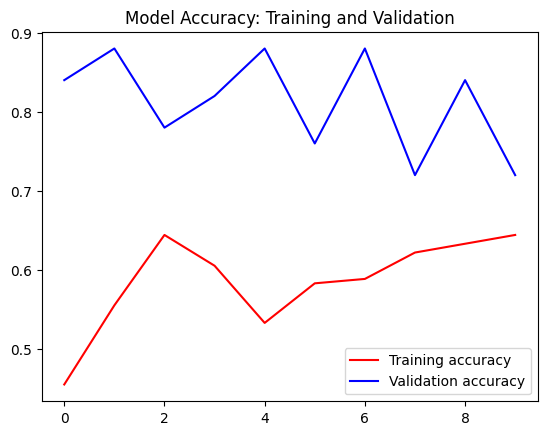

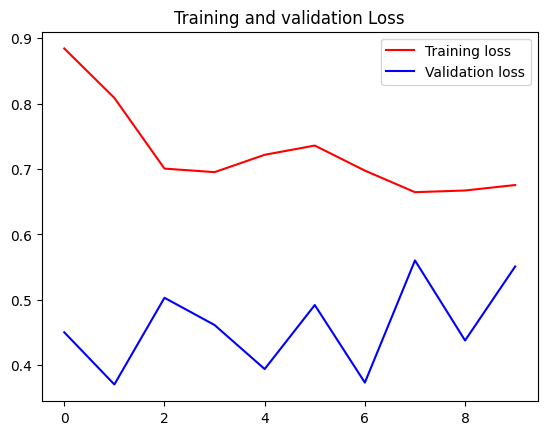

<Figure size 640x480 with 0 Axes>

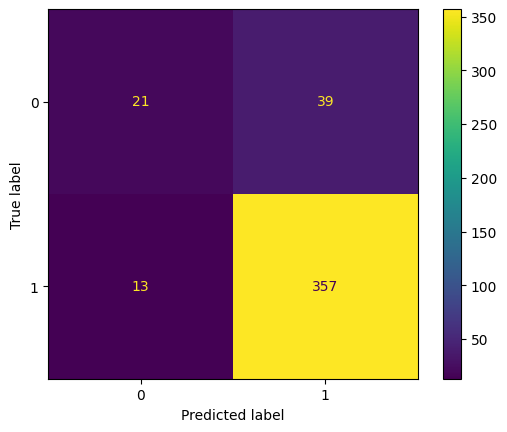


               precision    recall  f1-score   support

           0       0.62      0.35      0.45        60
           1       0.90      0.96      0.93       370

    accuracy                           0.88       430
   macro avg       0.76      0.66      0.69       430
weighted avg       0.86      0.88      0.86       430

Sensitivity: 0.965 Specificity: 0.35 Precision: 0.862 ROC_AUC_SCORE: 0.795



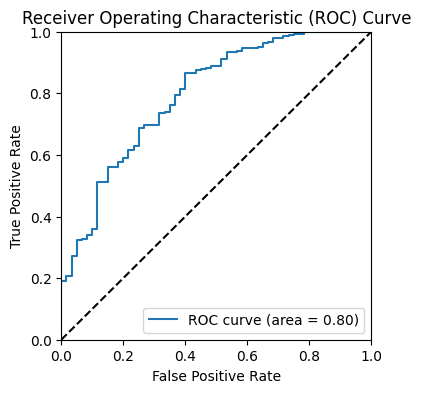

Validation complete...
Traning for Fold: 2
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.5556
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_2.hdf5
18/18 [==============================] - 75s 1s/step - loss: 0.7616 - accuracy: 0.5556 - val_loss: 0.5088 - val_accuracy: 0.8000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.5667
Epoch 2: val_accuracy did not improve from 0.80000
18/18 [==============================] - 10s 563ms/step - loss: 0.7114 - accuracy: 0.5667 - val_loss: 0.4391 - va

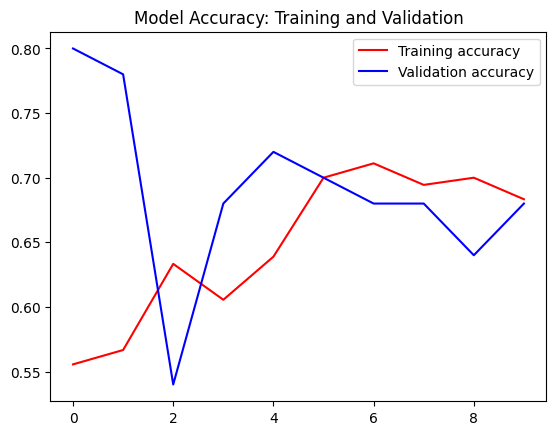

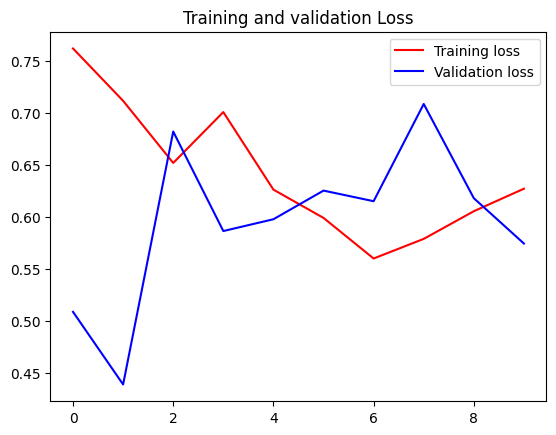

<Figure size 640x480 with 0 Axes>

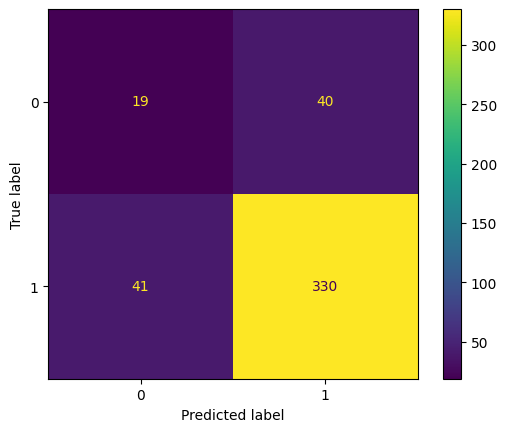


               precision    recall  f1-score   support

           0       0.32      0.32      0.32        59
           1       0.89      0.89      0.89       371

    accuracy                           0.81       430
   macro avg       0.60      0.61      0.61       430
weighted avg       0.81      0.81      0.81       430

Sensitivity: 0.889 Specificity: 0.322 Precision: 0.813 ROC_AUC_SCORE: 0.669



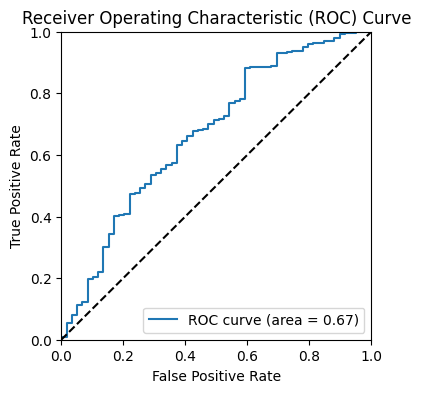

Validation complete...
Traning for Fold: 3
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.6000
Epoch 1: val_accuracy improved from -inf to 0.84000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_3.hdf5
18/18 [==============================] - 72s 1s/step - loss: 0.7271 - accuracy: 0.6000 - val_loss: 0.4108 - val_accuracy: 0.8400 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.6389
Epoch 2: val_accuracy improved from 0.84000 to 0.88000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_3.hdf5
18/18 [====

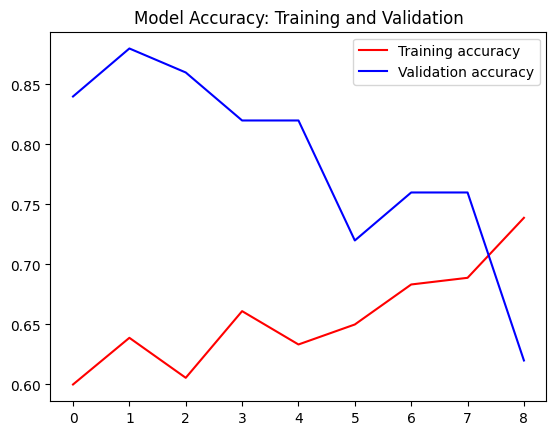

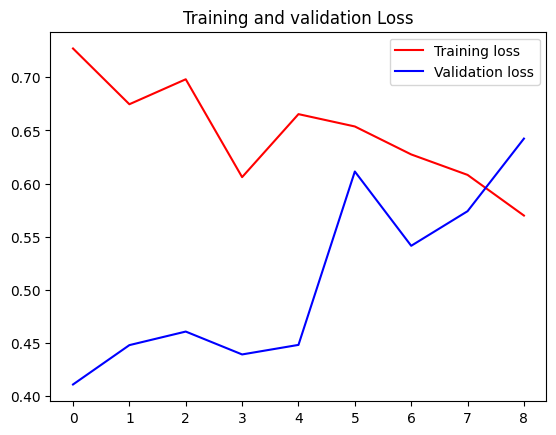

<Figure size 640x480 with 0 Axes>

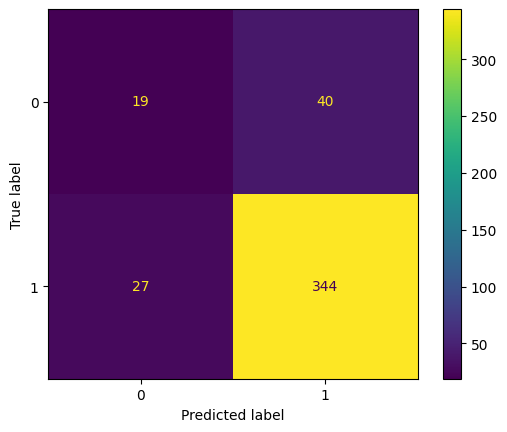


               precision    recall  f1-score   support

           0       0.41      0.32      0.36        59
           1       0.90      0.93      0.91       371

    accuracy                           0.84       430
   macro avg       0.65      0.62      0.64       430
weighted avg       0.83      0.84      0.84       430

Sensitivity: 0.927 Specificity: 0.322 Precision: 0.83 ROC_AUC_SCORE: 0.7



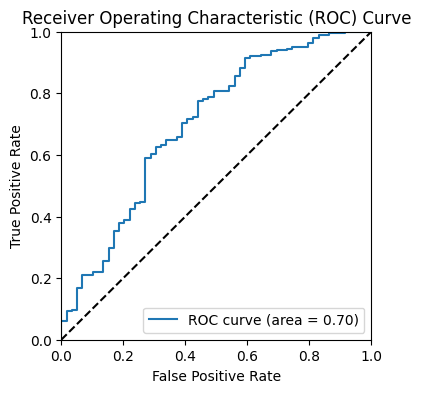

Validation complete...
Traning for Fold: 4
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.6556
Epoch 1: val_accuracy improved from -inf to 0.96000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_4.hdf5
18/18 [==============================] - 78s 1s/step - loss: 0.6885 - accuracy: 0.6556 - val_loss: 0.2520 - val_accuracy: 0.9600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.6111
Epoch 2: val_accuracy did not improve from 0.96000
18/18 [==============================] - 9s 521ms/step - loss: 0.6496 - accuracy: 0.6111 - val_loss: 0.2257 - val

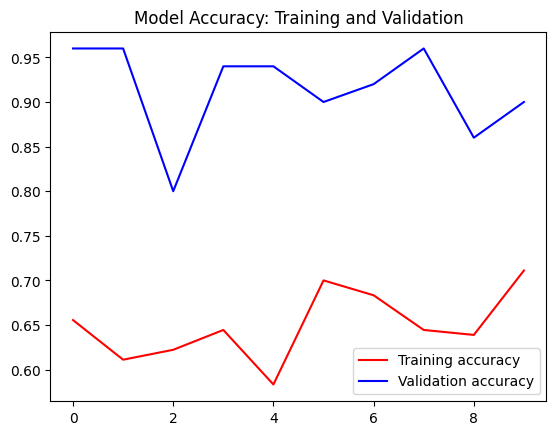

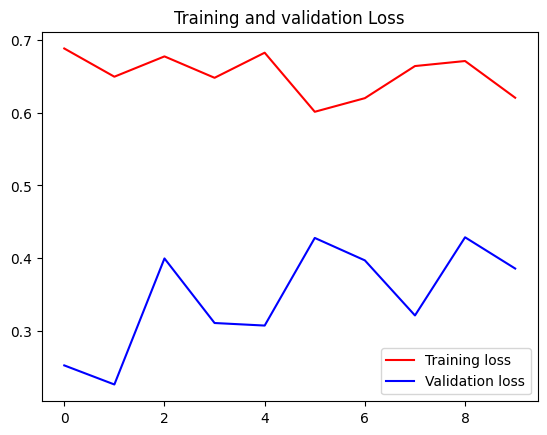

<Figure size 640x480 with 0 Axes>

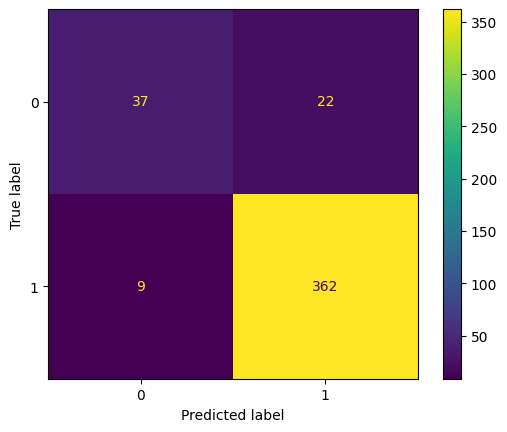


               precision    recall  f1-score   support

           0       0.80      0.63      0.70        59
           1       0.94      0.98      0.96       371

    accuracy                           0.93       430
   macro avg       0.87      0.80      0.83       430
weighted avg       0.92      0.93      0.92       430

Sensitivity: 0.976 Specificity: 0.627 Precision: 0.924 ROC_AUC_SCORE: 0.904



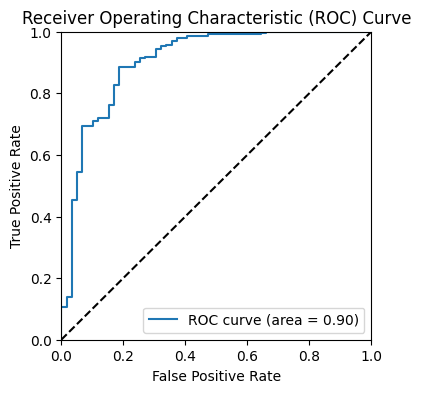

Validation complete...
Traning for Fold: 5
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6389
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_5.hdf5
18/18 [==============================] - 72s 1s/step - loss: 0.6679 - accuracy: 0.6389 - val_loss: 0.1853 - val_accuracy: 1.0000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.6222
Epoch 2: val_accuracy did not improve from 1.00000
18/18 [==============================] - 9s 522ms/step - loss: 0.7006 - accuracy: 0.6222 - val_loss: 0.3663 - val

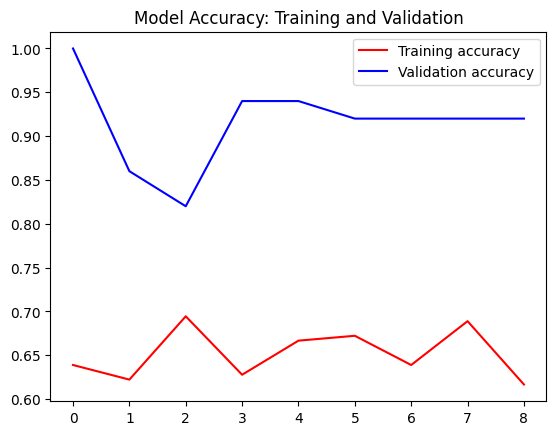

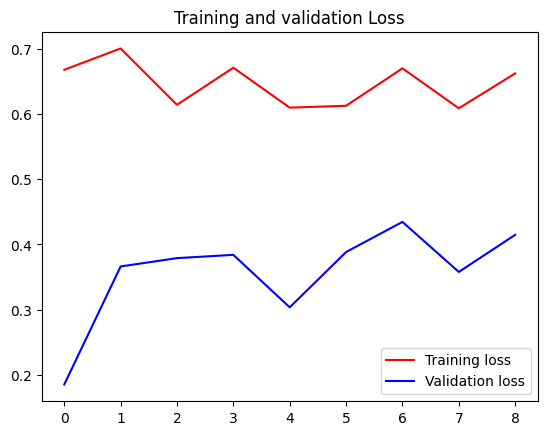

<Figure size 640x480 with 0 Axes>

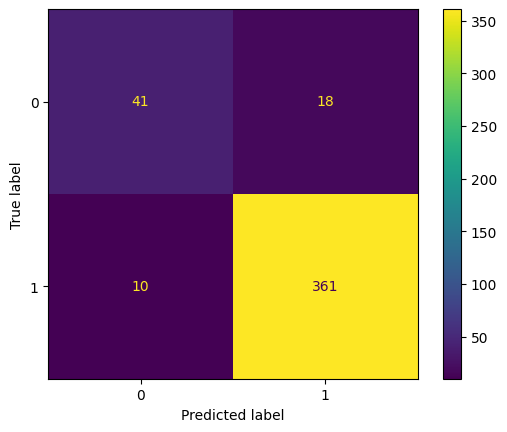


               precision    recall  f1-score   support

           0       0.80      0.69      0.75        59
           1       0.95      0.97      0.96       371

    accuracy                           0.93       430
   macro avg       0.88      0.83      0.85       430
weighted avg       0.93      0.93      0.93       430

Sensitivity: 0.973 Specificity: 0.695 Precision: 0.932 ROC_AUC_SCORE: 0.947



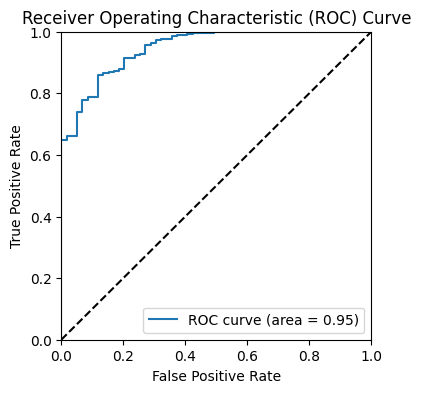

Validation complete...


In [16]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    #Model is evaluated uisng this validation data with shuffle = false and batch size = 1
    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


Test using model 1
600/600 [==============================] - 70s 116ms/step


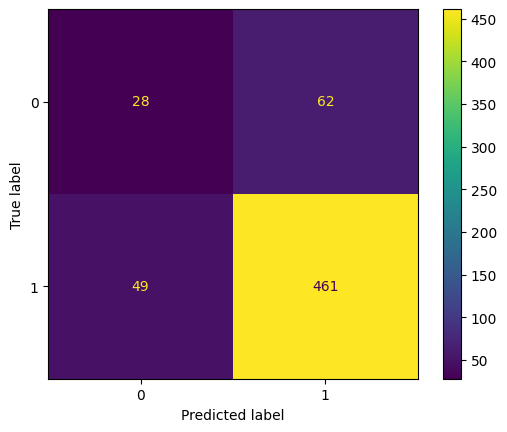


               precision    recall  f1-score   support

           0       0.36      0.31      0.34        90
           1       0.88      0.90      0.89       510

    accuracy                           0.81       600
   macro avg       0.62      0.61      0.61       600
weighted avg       0.80      0.81      0.81       600

Sensitivity: 0.904 Specificity: 0.311 Precision: 0.804 ROC_AUC_SCORE: 0.727



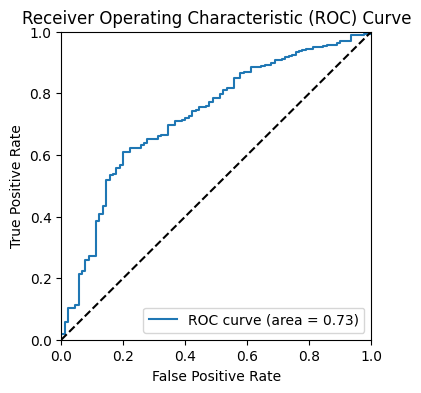

Testing Complete
Test using model 2
600/600 [==============================] - 27s 45ms/step


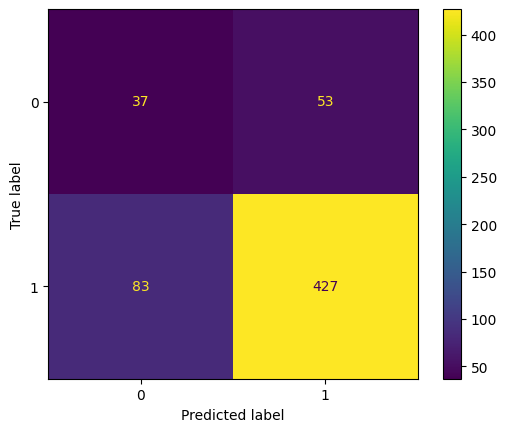


               precision    recall  f1-score   support

           0       0.31      0.41      0.35        90
           1       0.89      0.84      0.86       510

    accuracy                           0.77       600
   macro avg       0.60      0.62      0.61       600
weighted avg       0.80      0.77      0.79       600

Sensitivity: 0.837 Specificity: 0.411 Precision: 0.802 ROC_AUC_SCORE: 0.726



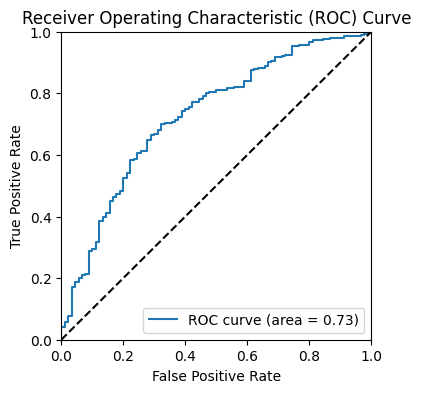

Testing Complete
Test using model 3
600/600 [==============================] - 28s 46ms/step


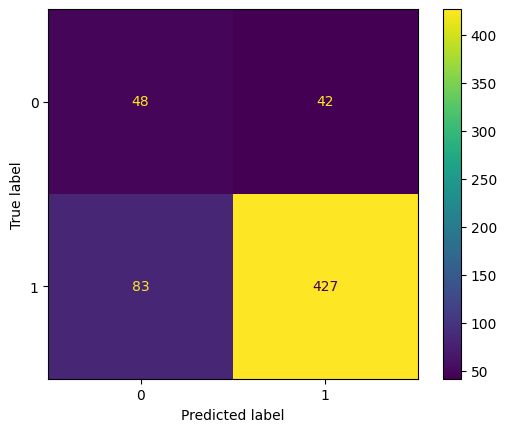


               precision    recall  f1-score   support

           0       0.37      0.53      0.43        90
           1       0.91      0.84      0.87       510

    accuracy                           0.79       600
   macro avg       0.64      0.69      0.65       600
weighted avg       0.83      0.79      0.81       600

Sensitivity: 0.837 Specificity: 0.533 Precision: 0.829 ROC_AUC_SCORE: 0.742



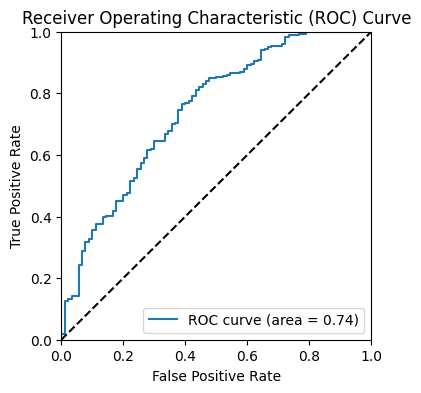

Testing Complete
Test using model 4
600/600 [==============================] - 28s 47ms/step


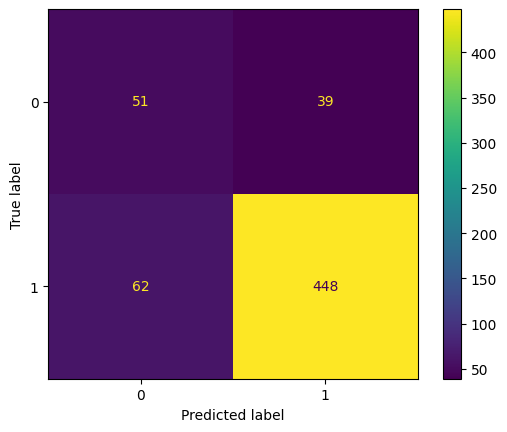


               precision    recall  f1-score   support

           0       0.45      0.57      0.50        90
           1       0.92      0.88      0.90       510

    accuracy                           0.83       600
   macro avg       0.69      0.72      0.70       600
weighted avg       0.85      0.83      0.84       600

Sensitivity: 0.878 Specificity: 0.567 Precision: 0.85 ROC_AUC_SCORE: 0.781



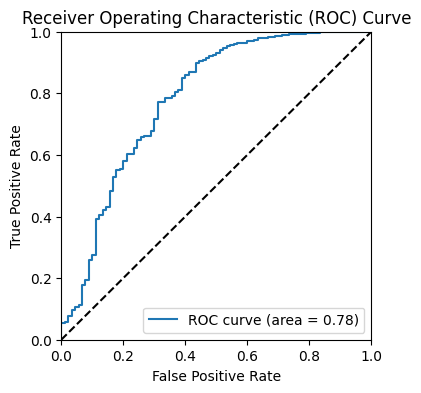

Testing Complete
Test using model 5
600/600 [==============================] - 29s 48ms/step


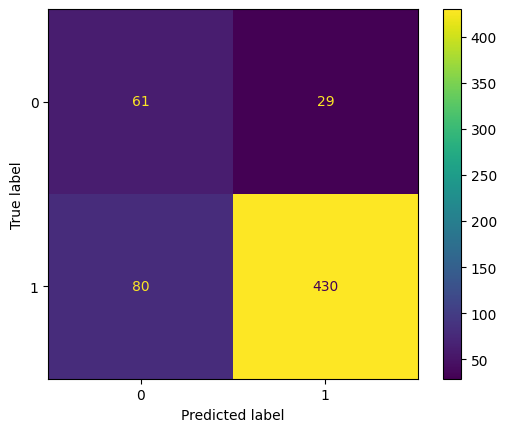


               precision    recall  f1-score   support

           0       0.43      0.68      0.53        90
           1       0.94      0.84      0.89       510

    accuracy                           0.82       600
   macro avg       0.68      0.76      0.71       600
weighted avg       0.86      0.82      0.83       600

Sensitivity: 0.843 Specificity: 0.678 Precision: 0.861 ROC_AUC_SCORE: 0.856



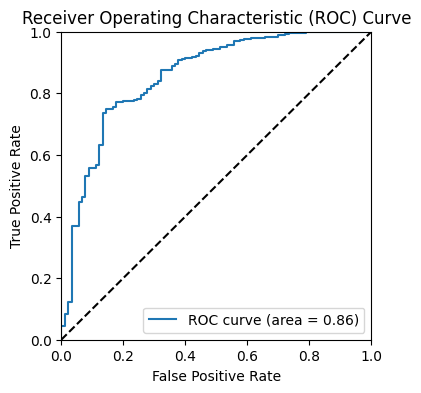

Testing Complete


In [17]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")